In [1]:
import sys
sys.path.insert(0,'/home/bcs/lib/controller-models')
from ControllerModels.IDTMController import IDTMController

In [2]:
import imp
import os
import logging

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import statsmodels

from BuildingControlsSimulator.Simulator.Simulator import Simulator
from BuildingControlsSimulator.Simulator.Config import Config
from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.ControllerModels.Deadband import Deadband
from BuildingControlsSimulator.DataClients.LocalDestination import LocalDestination
from BuildingControlsSimulator.DataClients.DataSpec import DonateYourDataSpec
from BuildingControlsSimulator.DataClients.DataClient import DataClient
from BuildingControlsSimulator.DataClients.GCSDYDSource import GCSDYDSource
from BuildingControlsSimulator.OutputAnalysis.OutputAnalysis import OutputAnalysis
from BuildingControlsSimulator.StateEstimatorModels.LowPassFilter import LowPassFilter

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2


In [3]:
!energyplus --version

EnergyPlus, Version 9.4.0-998c4b761e


In [4]:
dyd = DataClient(
    source=GCSDYDSource(
        gcp_project=os.environ.get("DYD_GOOGLE_CLOUD_PROJECT"),
        gcs_uri_base=os.environ.get("DYD_GCS_URI_BASE"),
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        meta_gcs_uri=os.environ.get("DYD_METADATA_URI"),
    ),
    destination=LocalDestination(
        local_cache=os.environ.get("LOCAL_CACHE_DIR"),
        data_spec=DonateYourDataSpec(),
    ),
    nrel_dev_api_key=os.environ.get("NREL_DEV_API_KEY"),
    nrel_dev_email=os.environ.get("NREL_DEV_EMAIL"),
    archive_tmy3_meta=os.environ.get("ARCHIVE_TMY3_META"),
    archive_tmy3_data_dir=os.environ.get("ARCHIVE_TMY3_DATA_DIR"),
    ep_tmy3_cache_dir=os.environ.get("EP_TMY3_CACHE_DIR"),
    simulation_epw_dir=os.environ.get("SIMULATION_EPW_DIR"),
)

In [5]:
meta = dyd.source.get_metadata()

In [6]:
sim_ids = meta[
    (meta["Model"] == "ecobee4") 
    & (meta["City"] == "Chicago")
    & (meta["Style"] == "detached")
    & (meta["installedCoolStages"] == 1)
    & (meta["Has a Heat Pump"] == False)
    & (meta["Number of Remote Sensors"] == 1)
    & (meta["Number of Floors"] == 1)
].sample(n=1, replace=False, random_state=2336).Identifier.to_list()

In [12]:
meta[
    (meta["Model"] == "ecobee4") 
    & (meta["City"] == "Phoenix")
    & (meta["Style"] == "detached")
    & (meta["installedCoolStages"] == 1)
    & (meta["Has a Heat Pump"] == False)
]

,Identifier,Model,UserID,Country,ProvinceState,City,Floor Area [ft2],Style,Number of Floors,Age of Home [years],...,installedHeatStages,allowCompWithAux,Has Electric,Has a Heat Pump,Auxilliary Heat Fuel Type,Number of Remote Sensors,First Connected,filename,eco+ enrolled,eco+ slider level
31658,8c00c9bb17bfcca53809cb1b2d033a448bc017df,ecobee4,24eb7c23e5e73bb824d8c73efe54b2bca5eefc3d,US,AZ,Phoenix,2500,detached,1,70,...,1,True,False,False,Gas,0,2017-06-08 23:14:48.0,8c00c9bb17bfcca53809cb1b2d033a448bc017df.csv,NaN,NaN
33248,d310f1c1f600c374d8975c753f7c0fb8de9c96b1,ecobee4,37b2f106569db3937f950c1aabaeb610372b177e,US,AZ,Phoenix,3500,detached,1,5,...,1,False,False,False,Gas,1,2017-06-22 21:11:57.0,d310f1c1f600c374d8975c753f7c0fb8de9c96b1.csv,NaN,NaN
33981,f0d3ea8cbfe21ae0654a3cff7ddb07501203d63d,ecobee4,5ebe581d196128f2bb253c5a469942ef0014c78d,US,AZ,Phoenix,2500,detached,1,60,...,1,False,False,False,Gas,5,2017-06-29 02:42:03.0,f0d3ea8cbfe21ae0654a3cff7ddb07501203d63d.csv,NaN,NaN
38994,4d052091204bac49b8cd9f6e1ca7855310e301cd,ecobee4,b89a04e21deee820ad27f7c0f4db53440045aac9,US,AZ,Phoenix,3500,detached,1,20,...,1,False,False,False,Gas,1,2017-08-28 00:12:34.0,4d052091204bac49b8cd9f6e1ca7855310e301cd.csv,NaN,NaN
39755,e44f61f4ed44ee2526d41249317c7e2e357bd9b2,ecobee4,20f72dabb012b663bff4838c1fcbb97692d703d1,US,AZ,Phoenix,2500,detached,1,40,...,1,False,False,False,Gas,3,2017-09-08 06:17:22.0,e44f61f4ed44ee2526d41249317c7e2e357bd9b2.csv,NaN,NaN
40053,a2548647b7e7aa2c2b22fc9ecc5766d81167853b,ecobee4,3a0527fbb6c18f26294d764a03efc9d26054ba43,US,AZ,Phoenix,2500,detached,1,85,...,1,False,False,False,Gas,0,2017-09-13 21:46:51.0,a2548647b7e7aa2c2b22fc9ecc5766d81167853b.csv,NaN,NaN
47749,3c9c332c023bcfa1f9910cf5208521c66460070c,ecobee4,7eaa22ea34ad354e5a100c6efee0884e66a6e76c,US,AZ,Phoenix,2500,detached,2,10,...,1,False,False,False,Gas,4,2017-12-01 02:33:08.0,3c9c332c023bcfa1f9910cf5208521c66460070c.csv,NaN,NaN
48407,5ba718fb2ba66592397501687ed7c4e1244126ef,ecobee4,2bed0e026f99a902778f686c37aa446f39bde39c,US,AZ,Phoenix,3000,detached,2,0,...,1,False,False,False,Gas,0,2017-12-03 23:15:34.0,5ba718fb2ba66592397501687ed7c4e1244126ef.csv,NaN,NaN
48408,8ab6690c5196c767a3b984f62a7bb4f5985a700b,ecobee4,2bed0e026f99a902778f686c37aa446f39bde39c,US,AZ,Phoenix,3000,detached,2,0,...,1,False,False,False,Gas,1,2017-12-03 23:21:54.0,8ab6690c5196c767a3b984f62a7bb4f5985a700b.csv,NaN,NaN
51218,388548460f6880d0980c7b784bbb4897a05909cb,ecobee4,37633ff23f62c28ee619ff92dbbcc3fce834df87,US,AZ,Phoenix,4000,detached,1,17,...,1,False,False,False,Gas,2,2017-12-23 20:18:17.0,388548460f6880d0980c7b784bbb4897a05909cb.csv,NaN,NaN


In [7]:
sim_ids = ["2e7467a283eaa1ab1d435bca6d7a36017e0fabf6"]

In [8]:
sim_config = Config.make_sim_config(
    identifier=sim_ids,
    latitude=33.481136,
    longitude=-112.078232,
    start_utc="2018-01-15",
    end_utc="2018-01-17",
    min_sim_period="1D",
    sim_step_size_seconds=60,
    output_step_size_seconds=300,
)

In [9]:
_fmu_path = os.path.join(os.environ.get("DOCKER_CONTROLLER_DIR"), "fmu/idtm/idtm_6d756360e21b_b323c179.fmu")
_xml_path = os.path.join(os.environ.get("DOCKER_CONTROLLER_DIR"), "test/data/thermostat_apollo_FA_H1C1_HP0_n1.xml")
_hvac_temp_data_xml_path = os.path.join(os.environ.get("DOCKER_CONTROLLER_DIR"), "test/data/hvacTempData.xml")
_config_dir = os.path.join(os.environ.get("DOCKER_CONTROLLER_DIR"), "config")

In [75]:
%%time
master = Simulator(
    data_client=dyd,
    sim_config=sim_config,
    building_models=[
        EnergyPlusBuildingModel(
            idf=IDFPreprocessor(idf_file="/home/bcs/lib/building-controls-simulator/test/idf/v9-4-0/IL_Chicago_gasfurnace_heatedbsmt_IECC_2018_940_2000.idf",),
        )
    ],
    state_estimator_models=[
        LowPassFilter(alpha_temperature=0.2, alpha_humidity=0.2)
    ],
    controller_models=[
        IDTMController(
            fmu_path=_fmu_path,
            config_xml_path=_xml_path,
            hvac_data_path=_hvac_temp_data_xml_path,
            config_dir=_config_dir,
            step_size_seconds=60,
    )],
)


CPU times: user 1 s, sys: 10 ms, total: 1.01 s
Wall time: 1.02 s


In [76]:
%%time
# simulate
master.simulate(local=True, preprocess_check=False)

/home/bcs/.local/share/virtualenvs/building-controls-simulator-_QCXB2qn/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



CPU times: user 1min 33s, sys: 2.71 s, total: 1min 35s
Wall time: 1min 36s


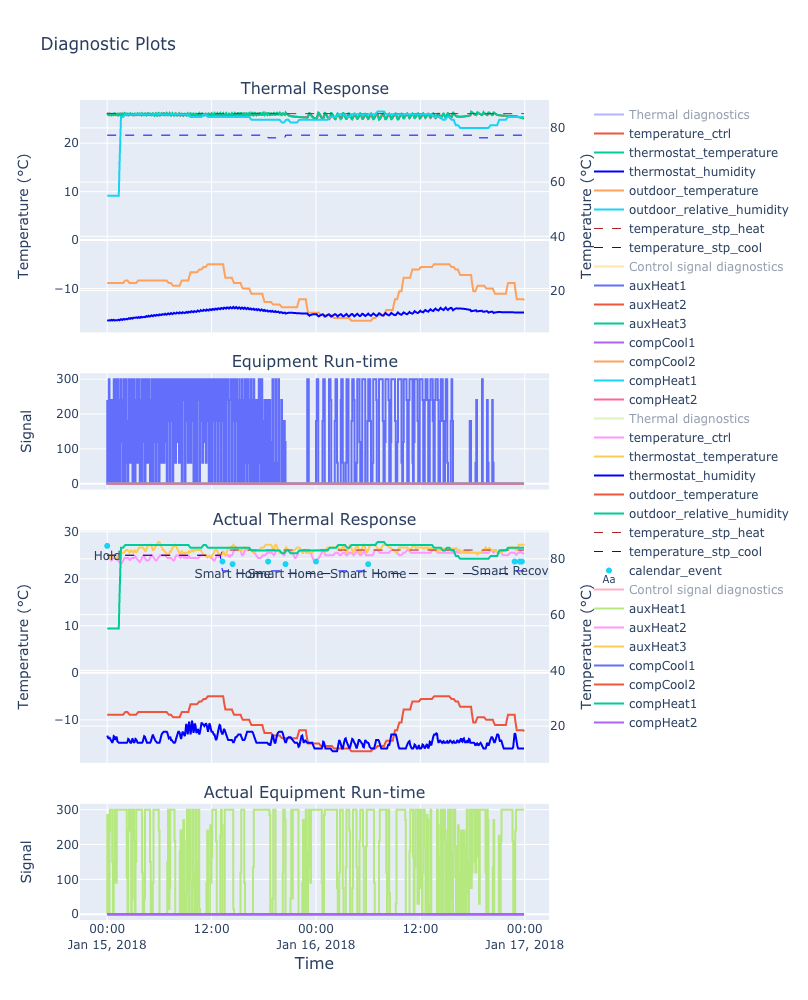

In [77]:
sim_analysis = OutputAnalysis(output_df=master.simulations[0].output, input_df=master.simulations[0].full_input, data_spec=dyd.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=True)